In [37]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, RocCurveDisplay, roc_auc_score
from hyperopt import hp, fmin, tpe, Trials
import os
import json
from tqdm import tqdm

In [30]:
df = pd.read_csv('../inputs/Bank Customer Churn Prediction.csv')
df = df.drop('customer_id', axis=1)
mapa = {'Female': 0, 'Male': 1}
df['gender'] = df['gender'].map(mapa)
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,1,39,5,0.00,2,1,0,96270.64,0
9996,516,France,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,0,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,1,42,3,75075.31,2,1,0,92888.52,1


In [6]:
y = df['churn']
X = df.drop('churn', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'depth': hp.quniform('depth', 4, 15, 1),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0.0, 2.0),
    'iterations': hp.quniform('iterations', 100, 1000, 20)
}
def objective(params):
    clf = CatBoostClassifier(eval_metric='Accuracy',
                             **params)
    clf.fit(X_train, y_train, cat_features=['country'], verbose=0)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return 1-acc

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            show_progressbar=True,
            verbose=True,
            )
model = CatBoostClassifier(eval_metric='Accuracy',
                           **best)
model.fit(X_train, y_train, cat_features=['country'],
          verbose=0,
          eval_set=Pool(X_test, y_test, cat_features=['country']),
          use_best_model=True,
          plot=True)


100%|███████████████████████████████████████████████| 50/50 [35:07<00:00, 42.15s/trial, best loss: 0.13049999999999995]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
best

{'depth': 6.0,
 'iterations': 360.0,
 'l2_leaf_reg': 1.8471254292955186,
 'learning_rate': 0.09501862624176438}

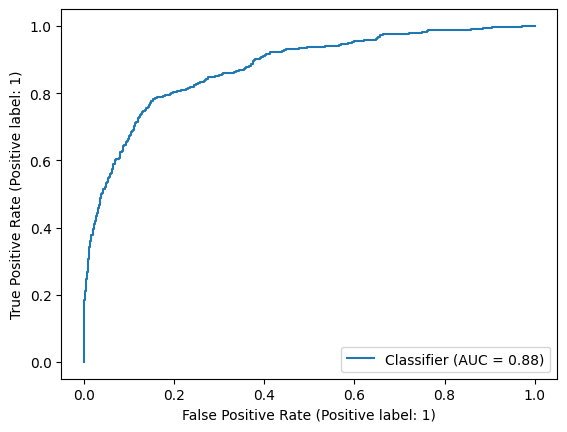

In [40]:
y_proba = model.predict_proba(X_test)
y_proba = [i[1] for i in y_proba]
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=y_proba)

In [54]:
m = X_test.copy()
m['Вер-ть оттока'] = y_proba # вер-ть ухода
m

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,Вер-ть оттока
6252,596,Germany,1,32,3,96709.07,2,0,0,41788.37,0.050263
4684,623,France,1,43,1,0.00,2,1,1,146379.30,0.034632
1731,601,Spain,0,44,4,0.00,2,1,0,58561.31,0.146014
4742,506,Germany,1,59,8,119152.10,2,1,1,170679.74,0.203012
4521,560,Spain,0,27,7,124995.98,1,1,1,114669.79,0.094668
...,...,...,...,...,...,...,...,...,...,...,...
6412,602,Germany,0,53,5,98268.84,1,0,1,45038.29,0.622903
8285,609,France,1,25,10,0.00,1,0,1,109895.16,0.098145
7853,730,France,0,47,7,0.00,1,1,0,33373.26,0.776638
1095,692,France,1,29,4,0.00,1,1,0,76755.99,0.136210


In [18]:
model.save_model('../models/model.cbm')

In [25]:

import pandas as pd

# Создание DataFrame с двумя пользователями
data = {
    'credit_score': [596, 623],
    'country': ['Germany', 'France'],
    'gender': [1, 1],
    'age': [32, 43],
    'tenure': [3, 1],
    'balance': [96709.07, 0.0],
    'products_number': [2, 2],
    'credit_card': [0, 1],
    'active_member': [0, 1],
    'estimated_salary': [41788.37, 146379.3]
}

df = pd.DataFrame(data)

print(df)

   credit_score  country  gender  age  tenure   balance  products_number  credit_card  active_member  estimated_salary
0           596  Germany       1   32       3  96709.07                2            0              0          41788.37
1           623   France       1   43       1      0.00                2            1              1         146379.30


In [28]:
demo = model.predict_proba(df)
demo

array([[0.9497373, 0.0502627],
       [0.9653677, 0.0346323]])

In [31]:
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,1,39,5,0.00,2,1,0,96270.64,0
9996,516,France,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,0,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,1,42,3,75075.31,2,1,0,92888.52,1


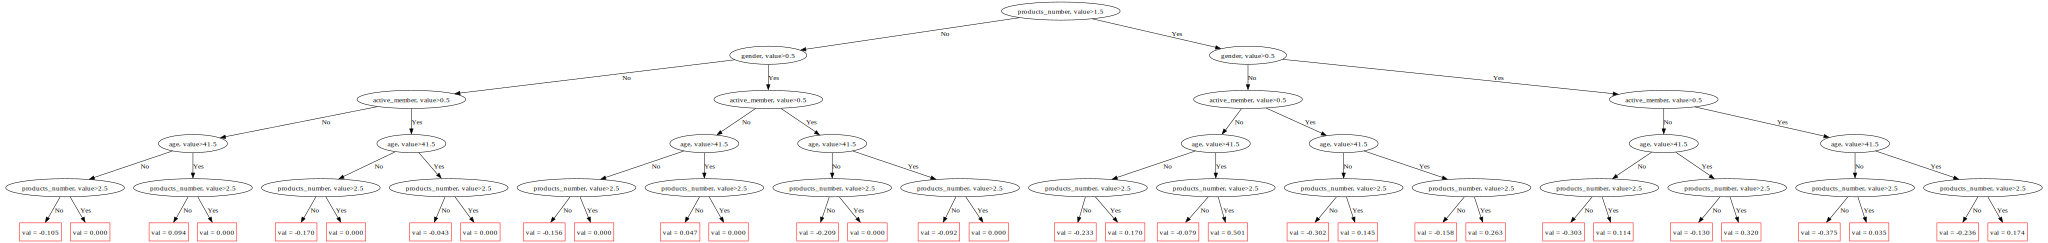

In [35]:
pool = Pool(X, y, cat_features=['country'], feature_names=list(X.columns))
model.plot_tree(0, pool)

<AxesSubplot: xlabel='names'>

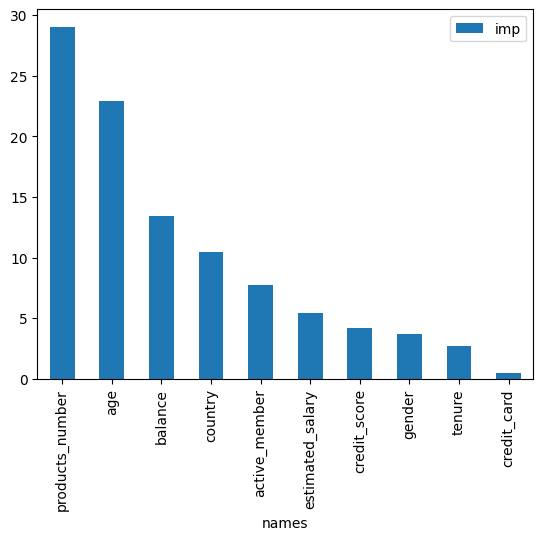

In [51]:
import matplotlib.pyplot as plt
y = model.feature_importances_
x = model.feature_names_
pd.DataFrame({'names': x, 'imp': y}).set_index(
    'names').sort_values('imp', ascending=False).plot.bar()